In [1]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
eps = 0.01
num_classes = 10

In [3]:
model_name = 'sgd_120'

In [4]:
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
def load_model(model_name):
    model = model_from_json(open('models/' + model_name + '_model.json').read())
    model.load_weights('weights/' + model_name + '_weights.h5')

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

    return model

In [14]:
def predict(x, model_name):
    model = load_model(model_name)
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [15]:
def generate_grads(x, label, model_name):
    
    model = load_model(model_name)
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(32,32,3)

In [16]:
def generate_adv(x, label, model_name, eps):
    x = x.reshape(32,32,3)
    p = np.sign(generate_grads(x, label, model_name))
    adv = (x - eps*p).clip(min=0, max=1)
    
    return adv

In [17]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [18]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

50000 train samples
10000 test samples


In [19]:
# adv_train = np.load(f'npy/adv_train_sgd_120_eps01_.npy')
adv_test = np.load(f'npy/adv_test_sgd_120_eps01_.npy')

# print(adv_train.shape[0], 'adv_train samples')
print(adv_test.shape[0], 'adv_test samples')

10000 adv_test samples


In [20]:
model = load_model(model_name)
print(model.summary())

W0115 19:13:28.115988 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0115 19:13:28.139420 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0115 19:13:28.179216 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0115 19:13:28.182497 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0115 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [21]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.6072074479103088
Test accuracy : 0.7874


x


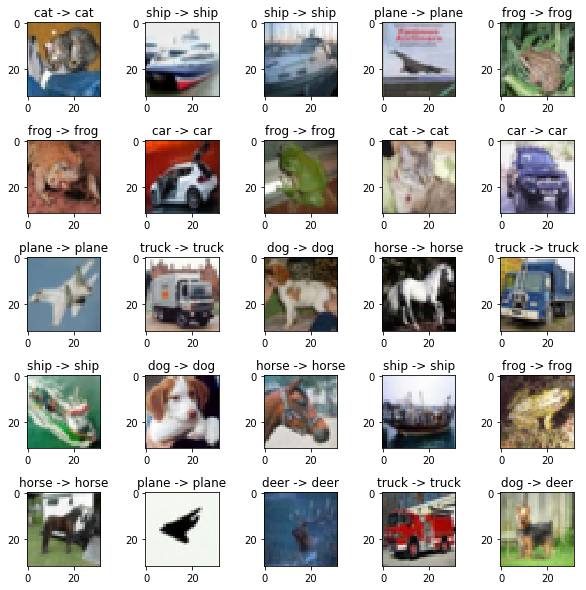

In [22]:
print('x')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = x_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()

In [23]:
score = model.evaluate(adv_test, y_test_catego, verbose=0)
print('adv')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv
Test loss : 2.145305345535278
Test accuracy : 0.3796


adv


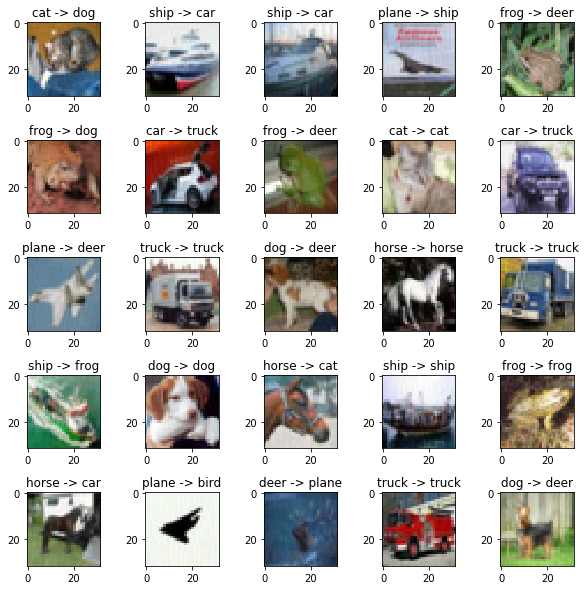

In [24]:
print('adv')
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    
    img = adv_test[i]
    pred_class, pred_per = predict(img, model_name)
    plt.imshow(img)
    plt.title(f'{label[int(y_test[i])]} -> {label[pred_class]}')

plt.show()